# Homework 1: Decision tree, K-nearest neighbor, and the Bias-Variance Trade-Off



This assignment is due on Moodle by **11:59pm on Friday Sep 11**.
Your solutions to theoretical questions should be done in Markdown/MathJax
directly below the associated question.
Your solutions to computational questions should include any specified Python
code and results
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors
and classmates,
but **you must write all code and solutions on your own**. For a refresher on
the course **Collaboration Policy** click
[here](https://github.com/BoulderDS/CSCI-4622-Machine-Learning-
fa20/blob/master/info/syllabus.md#collaboration-policy).

**NOTES**:

- Do **NOT** load or use any Python packages that are not available in Anaconda
(Version: 2019.07) with Python 3.7.
- Some problems with code may be autograded.  If we provide a function API, **do
not** change it.  If we do not provide a function API, then you're free to
structure your code however you like.
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar,
rar, zip, etc.

**Acknowledgment**: Noah Smith, Chris Ketelsen

**Please put your name and cuidentity key.**

**Name**: Chris Beggs

**Identity Key**: chbe2777

In [13]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### [30 points] Problem 1 - Decision tree
***

Consider the problem of predicting whether a person has a college degree based
on age, salary, and Colorado residency.
The dataset looks like the following.

| Age   | Salary         | Colorado Residency      | College degree|
|:------:|:------------:| :-----------:|---:|
| 27 | 41,000 | Yes | Yes |
| 61 | 52,000 | No | No |
| 23 | 24,000 | Yes | No |
| 29 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 57 | 120,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 41 | 45,000 | Yes | No |
| 53 | 26,000 | No | No |
| 48 | 65,000 | Yes | Yes |

**Part 1 [5 points]**: Convert the above table to data. Two variables should be
created:

1. $x$ is a $10*3$ matrix that contains the data from columns 0, 1, and 2.
Colorado residency is represented by 1 (yes) and 0 (no).
2. $y$ contains the labels (college degree), 1 (yes) and 0 (no).

In [14]:
 x = np.array([
 [27 , 41000 , 1], 
 [61 , 52000 , 0], 
 [23 , 24000 , 1], 
 [29 , 77000 , 1], 
 [32 , 48000 , 0], 
 [57 , 120000 , 1],
 [22 , 38000 , 1], 
 [41 , 45000 , 1], 
 [53 , 26000 , 0], 
 [48 , 65000 , 1 ]])

y=np.array([1,0,0,1,1,1,1,0,0,1])
print(x.shape)
print(y.shape)

(10, 3)
(10,)


**Part 2 [16 points]:** Criteria for choosing a feature to split.

**[2 points]** We start with no splitting. Assuming that our algorithm is
deterministic, what is the smallest number of mistakes we can make if we do not
use any of the features and what is the algorithm? (**Write your answer in the
Markdown cell below.**)

The smallest number of mistakes we can make without splitting is just choosing
the the classification with the least entries, so 4 is the smallest number of
mistakes/

**[5 points]** We start by considering the variable *Colorado residency*. The
first criteria is based on the number of mistakes. We need to build a
contingency table between Colorado residency and college degree.

How many mistakes will we make if we split based on Colorado residency?
(**Answer below by finishing the code.**)

In [15]:
def get_error_in_leaf(y, ids):
    """
    Returns the errors in a leaf node of a decision tree.
    This function can be used to answer the previous question automatically.
    
    :@param y: all labels
    :@param ids: the subset of indexes in the leaf node
    """
    elements, count = np.unique(y[ids], return_counts=True)
    return np.amin(count) 


def error_criteria(y, root, left_child, right_child):
    """
    Returns the number of errors if we split the root into the left child and the right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    return (get_error_in_leaf(y,left_child)) + (get_error_in_leaf(y,right_child)) 
def value_split_binary_feature(x, y, fid, root, criteria_func):
    
    root = root.tolist()
    left_child = [i for i in root if x[i, fid] == 0]
    right_child = [i for i in root if x[i, fid] == 1]
    return criteria_func(y, root, left_child, right_child)

# Colorado residency should correpsond to the third column in your data x
fid = 2
root = np.array(list(range(len(y)))) # root includes all data points
mistakes = value_split_binary_feature(x, y, fid, root, error_criteria)

In [16]:
# This cell is for grading purposes only; please ignore

**[3 points]** Alternatively, we can use information gain to split the data. To
get you familiar with MathJax, please write the equation necessary to compute
information gain if we split data $D$ into $D_1$ and $D_2$. **Write your answer
in the Markdown cell below.**

$$IG(D) = H(D) - H(D_1) - \frac{|D_1|}{|D|}H(D_1) - \frac{|D_2|}{|D|}H(D_2) $$

**[6 points]** Now we write a function for computing information gain. Use log2
for entropy computation.

In [17]:
def entropy(y, ids):
    """
    Returns the entropy in the labels for the data points in ids.
    
    :@param y: all labels
    :@param ids: the indexes of data points
    """
    if len(ids) == 0: # deal with corner case when there is no data point.
        return 0
    elements, counts = np.unique(y[ids], return_counts=True)
    ids = np.array(ids)
    
    ent = 0.0
    for i in range(elements.shape[0]):
        ent -= (counts[i]/ids.shape[0] * math.log2(counts[i]/ids.shape[0]))
    return ent
        
    
def information_gain_criteria(y, root, left_child, right_child):
    """
    Returns the information gain by splitting root into left child and right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    info_gain = entropy(y, root)
    info_gain -= (entropy(y,left_child) + entropy(y,right_child)) 
    return info_gain
fid = 2
root = np.array(list(range(len(y)))) # root includes all data points
info_gain = value_split_binary_feature(x, y, fid, root, information_gain_criteria)    

In [18]:
# This cell is for grading purposes only; please ignore

**Part 3 [9 points]**: Deal with continuous features.

**[6 points]** One way to deal with continuous (or ordinal) data is to define
binary features based on thresholding of continuous features like Age and
Salary.
For example, you might convert ages to 0 if age is less than or equal to 50 and
1 otherwise.

In [19]:
def value_split_continuous_feature(x, y, fid, root, criteria_func=information_gain_criteria):
    """
    Return the best value and its corresponding threshold by splitting based on a continuous feature.

    :@param x: all feature values
    :@param y: all labels
    :@param fid: feature id to split the tree based on
    :@param root: indexes of all the data points in the root
    :@param criteria_func: the splitting criteria function
    """
    best_value, best_thres = 0, 0
    features = np.copy(x)
    for i in range(len(x)):
        split_val = x[i][fid]
        
        features[:,fid][features[:,fid] < split_val] = 0
        features[:,fid][features[:,fid] >= split_val] = 1
        
        left_child = features[:,fid][features[:,fid] != 1 ]
        right_child = features[:,fid][features[:,fid] == 1 ]
        root = features[:,fid]
         
        curr_val = criteria_func(y, root, left_child, right_child)
        
        if curr_val > best_value:
            best_value = curr_val
            best_thres = split_val
    
    return best_value, best_thres

root = np.array(range(len(y))) # root includes all data points
fid = 0
age_value, age_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
fid = 1
salary_value, salary_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
print("Age Value" , age_value , "Age thres" , age_thres)
print("salary Value" , salary_value , "salary thres" , salary_thres)

Age Value 0.7219280948873623 Age thres 27
salary Value 0.8812908992306927 salary thres 41000


In [20]:
# This cell is for grading purposes only; please ignore

In [21]:
# This cell is for grading purposes only; please ignore

**[3 points]** Based on the current information gain by splitting different
features, if we build a decision stump (decision tree with depth 1) greedily,
which feature should we choose? Why? **Write down your answer in the Markdown
cell below.**

We would choose Salary, since we gain more information from that split.

**Extra credit [5 points]**: You now have all the ingredients to build a
decision tree recursively. You can build a decision tree of depth two and report
its classification error on the training data and the tree.

In [22]:
class LeafNode:
    """
    Class for leaf nodes in the decision tree
    """
    
    def __init__(self, label, count, total):
        """
        :@param label: label of the leaf node
        :@param count: number of data points with class 'label' falling in this leaf
        :@param count: number of datapoints of any label falling in this leaf
        """
        self.label = label
        self.count = count
        self.total = total
        
    def predict(self, x):
        """
        Return predictions for features x

        :@param x: feature values
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def display(self, feat_names, out_str, depth=0):
        """
        Display contents of a leaf node
        """
        prefix = '\t'*depth
        error = 1.0 - self.count / float(self.total)
        out_str += f'{prefix}leaf: label={self.label}, error={error} ({self.count}/{self.total} correct)\n'
        return out_str
    
class TreeNode:
    """
    Class for internal (non-leaf) nodes in the decision tree
    """
    def __init__(self, feat_id, feat_val):
        """
        :@param feat_id: index of the feature that this node splits on
        :@param feat_val: threshold for the feature that this node splits on
        """
        self.feat_id = feat_id
        self.feat_val = feat_val
        self.left = None
        self.right = None
    
    def split(self, x, root):
        """
        Given the datapoints falling into current node, return two arrays of indices in x corresponding to the
        left and right subtree
        
        :@param x: all feature values
        :@param root: indexes of all the data points in the current node
        """
        root = np.array(root)
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def predict(self, x):
        """
        Return an array of predictions for given 'x' for the current node
        
        :@param x: datapoints
        """
        assert self.left is not None and self.right is not None, 'predict called before fit'
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def display(self, feat_names, out_str, depth=0):
        """
        Display contents of a non-leaf node
        """
        prefix = '\t'*depth
        out_str += f'{prefix}{feat_names[self.feat_id]}\n'
        out_str += f'{prefix}x <= {self.feat_val}\n'
        out_str = self.left.display(feat_names, out_str, depth=depth+1)
        out_str += f'{prefix}x > {self.feat_val}\n'
        out_str = self.right.display(feat_names, out_str, depth=depth+1)
        return out_str

class DecisionTree:
    """
    Class for the decision tree
    """
    def __init__(self, max_depth=1, criteria_func=information_gain_criteria, binary_feat_ids=[]):
        """
        :@param max_depth: Maximum depth that a decision tree can take
        :@param criteria_func: criteria function to split features
        :@param binary_feat_id: list of indexes of binary features
        """
        self.max_depth = max_depth
        self.criteria_func = criteria_func
        self.binary_feat_ids = binary_feat_ids
        self.root = None
        self.x = None
        self.y = None
        
    def fit(self, x, y):
        """
        Fit a tree to the given dataset using a helper function
        """
        self.x = x
        self.y = y
        self.root = self.fit_helper(np.array(list(range(self.x.shape[0]))))
    
    def fit_helper(self, root, depth=1):
        """
        Recursive helper function for fitting a decision tree
        Returns a node (can be either LeafNode or TreeNode)
        
        :@param root: array of indices of datapoints which fall into the current node
        :@param depth: current depth of the tree being built 
        """
        
        """
        Strategy:
        1. If current partition is pure i.e. labels corresponding to all indices in root are the same
           OR the maximum depth has been reached, stop building the tree and return a LeafNode
        2. If not, find out the best feature to split on along with the threshold, create a TreeNode and 
           recursively call fit_helper on the two splits (You can assume the threshold for a binary feature 
           to be 0.5). Finally, return the current node 
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def predict(self, x):
        """
        Return predictions for a given dataset  
        """
        assert self.root is not None, 'fit not yet called'
        # YOUR CODE HERE
        raise NotImplementedError()
    
    
    def display(self, feat_names):
        assert self.root is not None, 'fit not yet called'
        out_str = ""
        out_str = self.root.display(feat_names, out_str)
        return out_str

In [23]:
# This cell is for grading purposes only; please ignore
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


### [35 points] Problem 2- KNN for Handwritten Digit Recognition
***

In this problem you'll implement a K-Nearest Neighbor framework to take an image
of a handwritten digit and predict which digit it corresponds to.

![Samples of Handwritten Digits](figs/mnist.png "MNIST Digits")

To keep run times down we'll only consider the subset of the MNIST data set
consisting of the digits $3, 7, 8$ and $9$.

**Part A [6 points]**: Executing the following cells will load training and
validation data and plot an example handwritten digit.  Explore the training and
validation sets and answer the following questions:

- How many pixels are in each image in the data set?
- How many total examples are there in the training set?
- How many total examples are there in the validation set?

In [24]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("data/mnist21x21_3789.pklz", "rb"))

In [25]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

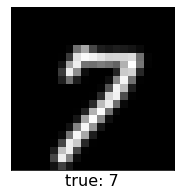

In [26]:
training_index = 0
view_digit(X_train[training_index], y_train[training_index])

In [27]:
# Write code for answering the questions in Part A and then put your answer in the Markdown cell below.
# Make sure to set each of the variables below to the correct value. Do not rename the variables.
N_pixels_per_img = X_train[0].shape[0]
N_training_examples = X_train.shape[0]
N_validation_examples = X_valid.shape[0]
print("N Pixels per image: " , N_pixels_per_img)
print("N training examples: " ,N_training_examples)
print("N validation examples: ", N_validation_examples)

N Pixels per image:  441
N training examples:  4000
N validation examples:  1000


In [28]:
# This cell is for grading purposes only; please ignore

N Pixels per image:  441

N training examples:  4000

N validation examples:  1000

In [29]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, X_train, y_train, K=5, distance_weighted=False):
        """
        Creates a kNN instance

        :param X_train: Training data input in 2D ndarray 
        :param y_train: Training data output in 1D ndarray 
        :param K: The number of nearest points to consider in classification
        :param distance_weighted: Bool indicating whether to use distance weighting
        """
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(X_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        # Boolean flag indicating whether to do distance weighting 
        self.distance_weighted = distance_weighted
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        """
        Input shapes:
                neighbor_indices: (p,)
                neighbor_distances: (p,)
            Where p is the number of features
        
        """
        # Handle case where query point is of zero distance
        if np.where(neighbor_distances == 0)[0].shape[0] > 0:
            dist_zero_indx = np.where(neighbor_distances == 0)[0].shape[0] 
            return self.y_train[dist_zero_indx] 
        
        dist_weights = None
        
        while True:
            
            nearest_labels = self.y_train[neighbor_indices]  # Labels of nearest vertices
            values, counts = np.unique(nearest_labels, return_counts=True) 
            max_count = np.max(counts)
            
            if self.distance_weighted:
                dist_weights = 1 / neighbor_distances
                
                
                classes = []  # classes is of the shape (num_classes) x (num instances for class i)
                
                # Get labels of all the closest vertexes
                for i in range(values.shape[0]):
                    classes.append(np.where(nearest_labels == values[i])[0])
                
                # Create a mask for each label
                class_masks = []
                for i in range(values.shape[0]):
                    cur_mask = np.ma.masked_where(nearest_labels!=values[i], nearest_labels)
                    cur_mask = np.ma.filled(cur_mask, fill_value=0)
                    class_masks.append(cur_mask)
                    
                    
                # Replace all non masked values with one
                for x in class_masks:
                    x[x != 0] = 1
                 
                # Mask out elements we don't care about, weight by distance, then sum
                scores = np.empty(len(classes))
                for i in range(values.shape[0]):
                    scores[i] = np.sum(dist_weights * class_masks[i])
                
                return values[np.where(scores == np.max(scores))[0][0]]
                
            
            if np.where(counts == max_count)[0].shape[0] > 1:  # If there is a tie for max count
                self.K -= 1 
                
                # Find the vertex index with the largest distance
                max_neighbor_distance = np.max(neighbor_distances)
                max_neighbor_indx = np.where(neighbor_distances == max_neighbor_distance)[0][0]
                
                # Remove the vertex with the largest distance, and try again.
                neighbor_distances = np.delete(neighbor_distances, max_neighbor_indx)
                neighbor_indices = np.delete(neighbor_indices, max_neighbor_indx)
                
            else:
                # Return the max label
                return values[np.where(counts == max_count)]
            
        
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        
        # Input is shape (p,) where p is the number of features
        x = x.reshape(1,-1)  # balltree.query wants shape (n_samples, n_features)
        
        distances, indices = self.balltree.query(x, k=self.K, return_distance=True)
        # distances and indices are of shape x.shape[:-1] + self.K
        # x.shape[:-1] is n_samples, so they will always be of size (1, self.K)
        
        return self.majority(indices[0], distances[0])
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        
        y_hat = np.empty(X.shape[0]) # Size (m,)
        
        for i in range(X.shape[0]):
            y_hat[i] = self.classify(X[i])  # X[i].shape = (p,)
        return y_hat
            



**Part B [10 points]**: Modify the class above to implement an Unweighted KNN
classifier.  There are three methods that you need to complete:

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples
each with $p$ features, return a length-$m$ vector of predicted labels by
calling the `classify` function on each example.
- `classify`: Given a single query example with $p$ features, return its
predicted class label as an integer using KNN by calling the `majority`
function.
- `majority`: Given an array of indices into the training set corresponding to
the $K$ training examples that are nearest to the query point, return the
majority label as an integer.  If there is a tie for the majority label using
$K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$
until there is a winning label.

**Notes**:
- Don't even think about implementing nearest-neighbor search or any distance
metrics yourself.  Instead, go read the documentation for Scikit-Learn's
[BallTree](http://scikit-
learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You
will find that its implemented [query](http://scikit-
learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query)
method can do most of the heavy lifting for you.
- **Do not** use Scikit-Learn's KNeighborsClassifier in this problem.  We're
implementing this ourselves.
- You don't need to worry about the `distance_weighted` flag until **Part C**,
but we recommend reading ahead a bit. It might be good to think about your
implementation of **Part C** before implementing **Part B**.
- When you think you're done, execute the following cell to run 4 unit tests
based on the example starting on Slide 15 of the [KNN
Lecture](https://chenhaot.com/courses/csci4622/slides/lec5.pdf).

In [30]:
from tests import tests
tests.run_test_suite('prob 2A', KNN)

test1NNclassify (tests.tests.TestUnweightedKNN) ... ok
test2NNclassify (tests.tests.TestUnweightedKNN) ... ok
test3NNclassify (tests.tests.TestUnweightedKNN) ... ok
test3NNpredict (tests.tests.TestUnweightedKNN) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


**Part C [5 points]**: Modify the `KNN` class to perform the distance-weighted
KNN classification.
The so-called Distance-Weighted KNN classifier assigns weights to the nearest-
neighbor training examples proportional to the inverse-distance from the
training example to the query point.  Classification is performed by summing the
weights associated with each class and predicting the class with the highest
weighted-majority vote.  Mathematically we might describe the weighted-vote for
a class $c$ as

$$
\textrm{Weighted-Vote}(c) = \displaystyle\sum_{i \in {\cal N}_K} I(y_i = c)
\times \dfrac{1}{\|{\bf x}_i - {\bf x}\|}
$$

A word of caution: it's certainly possible that a query point could be distance
$0$ away from some training example.  If this happens your implementation should
handle it gracefully and return the appropriate class label.

When you think you're done, execute the following cell to run three final unit
tests corresponding to the example on Slide 21 of the [KNN
Lecture](https://chenhaot.com/courses/csci4622/slides/lec5.pdf). Make sure that
the changes you make in **Part C** do not affect the unit tests from **Part B**.

In [31]:
from tests import tests
tests.run_test_suite('prob 2B', KNN)

test5NNclassify (tests.tests.TestWeightedKNN) ... ok
test3NNclassify (tests.tests.TestWeightedKNN) ... ok
test5NNpredict (tests.tests.TestWeightedKNN) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


**Part D [7 points]**: Use your `KNN` class to perform weighted KNN on the
validation data with $K=3$ and do the following:

- **[2 points]** Create a **confusion matrix** (feel free to use the Scikit-
Learn [confusion_matrix](http://scikit-
learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
function).

In [32]:
from sklearn.metrics import confusion_matrix

knn = KNN(X_train, y_train, K=3, distance_weighted=True)
yhat_valid = knn.predict(X_valid)
conf_matrix = confusion_matrix(y_valid, yhat_valid)

print(conf_matrix)

[[236   2  10   2]
 [  1 244   1   4]
 [  9   0 233   8]
 [  3   3   0 244]]


- **[2 points]** Based on your confusion matrix, which digits seem to get
confused with other digits the most?

3 seems to get confused as 8 the most, which makes sense


- **[3 points]** Find one misclassified validation example and plot it with the
`view_digit` function along with plots of its three nearest neighbors in the
training set.

PREDICTED CLASS: 9
ACTAL CLASS: 8


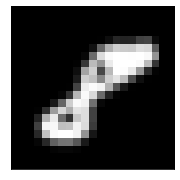

In [33]:
for i in range(0,N_validation_examples,10):
    y_hat = knn.predict(X_valid[i:i+10])
    compare = (y_hat == y_valid[i:i+10])
    incorrect = np.where(compare == False)[0]
    if incorrect.shape[0] > 0:
        print("PREDICTED CLASS:", int(y_hat[incorrect][0]))
        print("ACTAL CLASS:", y_valid[incorrect][0])
        view_digit(X_valid[i])
        break

**Part E [7 points]**: **[4 points]** Create a plot of the accuracy of both
Unweighted and Distance-Weighted KNN on the validation set on the same set of
axes for $K=1, 2, \ldots, 20$ (feel free to go out to $K=30$ if your
implementation is efficient enough to allow it).

START 1 
START 2 
FIN


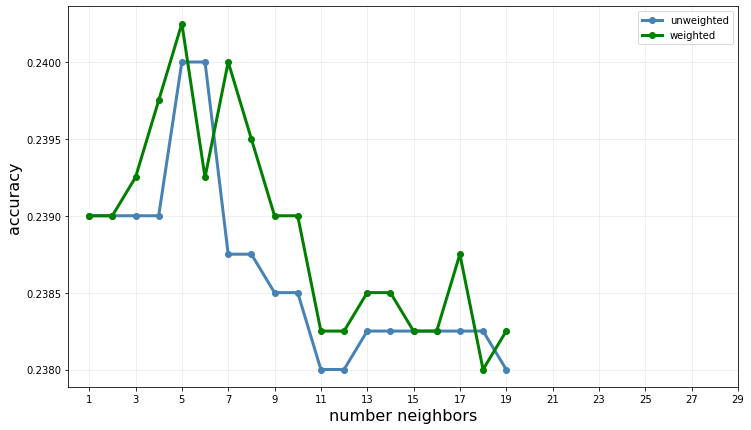

In [34]:

err_unweighted = []
err_weighted = []
print("START 1 ")
for i in range(1,20):
    knn = KNN(X_train, y_train, K=i, distance_weighted=True)
    yhat_valid = knn.predict(X_valid)
    compare = (yhat_valid == y_valid)
    correct = np.where(compare == True)[0]
    err_weighted.append(correct.shape[0]/y_train.shape[0])
    
print("START 2 ")
for i in range(1,20):
    knn = KNN(X_train, y_train, K=i, distance_weighted=False)
    yhat_valid = knn.predict(X_valid)
    compare = (yhat_valid == y_valid)
    correct = np.where(compare == True)[0]
    err_unweighted.append(correct.shape[0]/y_train.shape[0])
    
print("FIN")
acc = np.array(err_unweighted)
wacc = np.array(err_weighted)
allks = range(1, 20)

 
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, wacc, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(1, 31, 2))
ax.grid(alpha=0.25)

**[4 points]** Based on the plot, answer the following questions:

- For general $K$, does Unweighted or Weighted KNN appear to perform better?
- Which value of $K$ attains the best accuracy on the validation set?

Open questions: Why do you think this is the case? How can you explain this?

- The weighted seems to work better in most cases.

- The best K is 5 for both weighted and unweighted.

- Because of bias-variance trade off. When K is over some threshold, this corresponds to low model complexity, high bias and low variance. But when K is very small, this corresponds to high variance, high model complexity.

### [30 points] Problem 3 - Polynomial Regression  and the Bias-Variance Trade-
Off
***

In this problem you will use polynomial regression to explore the Bias-Variance
Trade-Off. Assume that our data comes from a model of the form

$$Y = f(X) + \epsilon ~~\textrm{ where }~~ \epsilon \sim N(0,\sigma^2)$$

For our experiments we'll use $f(x) = \sin(\pi x)$. The following functions can
be used to generate data from this distribution:

In [35]:
def get_f(x):
    """
    Returns sin(pi*x) for array of x values
    
    :@param x: ndarray of feature values
    """
    return np.sin(np.pi * x)

**Part A [6 points]**: **[3 points]** Generate a sample of size $n=20$ for
$x$-values chosen from a uniform distribution between $0$ and $1$.

In [36]:
def get_y(x, sigma=1.0):
    """
    Returns y values based on the data generation process.
    Note the noise term.
    
    :@param x: ndarray of feature values
    """
    return get_f(x) + (np.random.normal(loc=0, scale=sigma**2, size=x.shape[0]) % 1)
    
def sample(n, sigma=1.0):
    """Return tuples of data (x, y) that come from 
    the data generation process."""
    x = np.random.uniform(0, 1, size=n)
    y = get_y(x, sigma=sigma)
    return x, y

**[3 points]**: Make a scatter plot of the data overlayed with the curve of the
true function $f(x)=\sin(\pi x)$.

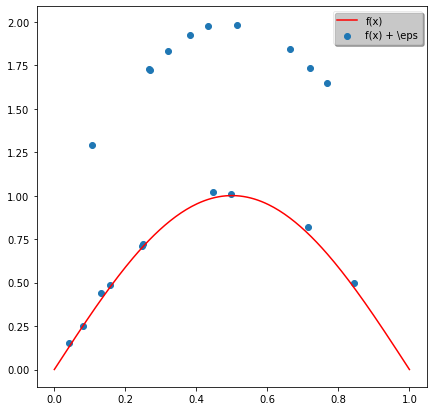

In [37]:
n = 20
x, y = sample(n, sigma=.15)
xplot = np.linspace(0, 1, 200)
fplot = get_f(xplot)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
plt.scatter(x=x, y=y, label="f(x) + \eps")
plt.plot(xplot,fplot, c='red', label="f(x)")
leg = plt.legend(loc='best', shadow=True)
leg.get_frame().set_alpha(0.4)
plt.show()


**Part B [6 points]**: **[3 points]** Next we need to create a function that can
fit a polynomial model to training data and make predictions for unseen data.
Complete the function `poly_predict` below to accomplish this.  Note that there
are many ways to do this in Python.  Later this week we'll look into doing this
with Scikit-Learn.  You're free to implement it using Scikit-Learn, but you
might want to look into Numpy's polynomial fitting functions,
[polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)
and
[polyval](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyval.html).

In [38]:
def poly_predict(x_train, y_train, x_valid, deg):
    """
    Function to train polynomial regression model on training data
    and then return a vector of predictions on validation data
    
    :@param x_train: vector of training features
    :@param y_train: vector of training responses
    :@param x_valid: vector of validation features to make predictions with
    :@param deg: degree of the polynomial model 
    """
    coeff = np.polyfit(x=x_train, y=y_train, deg=deg)
    fplot = np.polyval(p=coeff, x=x_valid)
    
    return fplot, coeff

**[3 points]**: Demonstrate that your function is working by using it to
generate a plot that include the true function $f(x)$, a scatter plot of your
training data, and the curve representing your fitted model.

Coefficients [-7.32510908  7.33984015 -0.13612989]


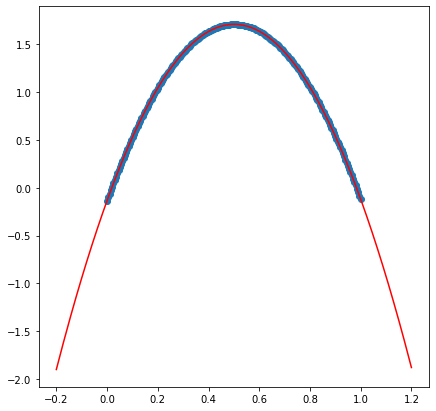

In [39]:
model_plot, coeff = poly_predict(x, y, xplot, 2)


fx = np.linspace(-0.2, 1.2, 200)
print("Coefficients", coeff)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
plt.scatter(x=xplot, y=model_plot)
plt.plot(fx, np.polyval(coeff, fx), c='red')
plt.show()



**Part C [12 points]**: Our goal now will be to make a plot of the decomposition
of the expected validation MSE into it's constituent parts.  Recall that we
showed in lecture that the expected test MSE can be written as

$$
\textrm{E}\left[\left(y_0 - \hat{f}(x_0) \right)^2\right] = \left[~f(x_0) -
\textrm{E}[~\hat{f}(x_0)~] \right]^2
+ \textrm{E}\left[ ~ \textrm{E}[~\hat{f}(x_0)]-\hat{f}(x_0)~\right]^2 +
\textrm{Var}(\epsilon)
= \left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 + \textrm{Var}(~\hat{f}(x_0)~) +
\textrm{Var}(\epsilon)
$$

where $x_0$ represents unseen validation data. We're going to run simulations to
estimate $\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2$ and
$\textrm{Var}(~\hat{f}(x_0)~)$ for different polynomial models and then plot
them against estimates of the true validation MSE. The function
`bias_variance_study` below will help you do this.  You just need to fill in a
few key parts.  At the end of the day, you should have a plot for each
combination of the simulation parameters.

The $\textrm{Bias}^2$ term is given by

$$
\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 = \left[~f(x_0) -
\textrm{E}[~\hat{f}(x_0)~] \right]^2
$$

The first term inside the square,$~f(x_0)$, is simply the true function $f$
evaluated on the validation data.  The second term inside the square,
$\textrm{E}[~\hat{f}(x_0)~]$, is the expected value of all estimated models
evaluated on the validation data.  We can estimate this by sampling many many
training sets, fitting models, evaluating them on many validation sets, and then
taking the average.

The next step is to estimate the $\textrm{Variance}$.  Let's unpack it

$$
\textrm{E}\left[ ~ \hat{f}(x_0) - \textrm{E}[~\hat{f}(x_0)]~\right]^2
$$

Note that $\textrm{E}[~\hat{f}(x_0)]$ is the `mean_model` we got from the
`squared_bias` function. The other term, $\hat{f}(x_0)$, is a model estimated on
a random training set, and then evaluated on the validation set.  Since we're
wrapping this whole thing in an expectation, we're going to sample many many
training sets, estimate $\hat{f}(x_0)$, and then compute the mean squared
deviation between these and the `mean_model`.

You will add code to the function below to accomplish this. The plotting part is
completed for you. Follow the instructions in the comments below to write two
loops.

In the first loop, you need to train models of different degrees on the training
set and record their validation predictions. You also need to calculate the
validation MSE of each model.

In the second loop, you need to calculate for each degree the squared bias, the
variance, and the mean validation MSE across all the simulations.

Mean difference between MSE and Bias**2 + variance with sigma=0.4:  0.16000000000000003


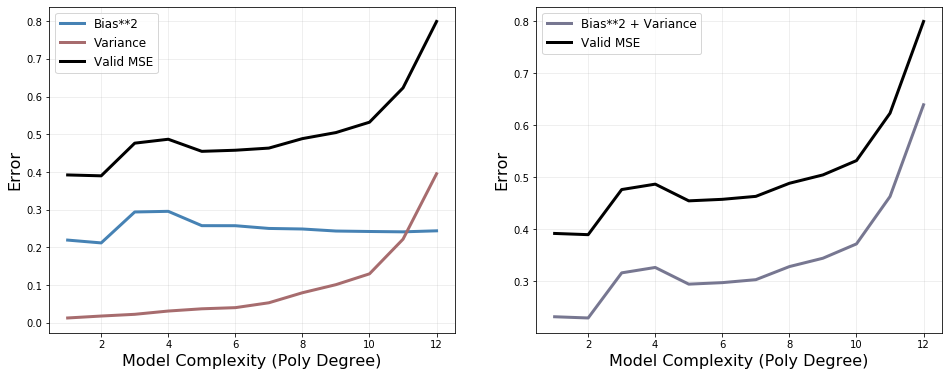

In [40]:
def bias_variance_study(num_data, num_sims, train_frac=0.8, sigma=0.4, max_deg=10, random_state=1234):
    '''
    Function to run simulations and estimate the squared-bias, variance, and 
    validation error of polynomial regression models. 
    
    :@param num_data: number of points in simulated data set 
    :@param num_sims: number of simulations to run 
    :@param train_frac: fraction of total data in training set
    :@param sigma: standard deviation of noise in data 
    :@param max_deg: largest degree polynomial to analyze
    :@param random_state: seed for random state, for reproducibility
    '''
    # Set random seed 
    np.random.seed(random_state)
    
    # array of polynomial degrees
    degrees = range(1, max_deg + 1)
    
    # train/valid split sizes 
    num_train = int(np.ceil(train_frac * num_data))
    num_valid = num_data - num_train
    
    # Generate grid of features and shuffle them 
    x_grid = np.linspace(-1, 1, num_data)
    np.random.shuffle(x_grid)
    
    # Spit into training and validation sets 
    x_train = x_grid[:num_train]
    x_valid = x_grid[num_train:]
    
    # Dictionaries for predictions and MSE measurements
    # Keys are polynomial degree. Each prediction is column 
    # of nValid x num_sims array. Each mse is entry in vector
    # of length num_sims 
    y_hat_valid = {deg: np.zeros((num_valid, num_sims)) for deg in degrees}
    mses_valid = {deg: np.zeros(num_sims) for deg in degrees}
    y_valid_arr = {deg: np.zeros((num_valid, num_sims)) for deg in degrees}
    
    # Loop over num_sims simulated data sets
    for sim in range(num_sims):
        
        # Generate training and validation responses 
        y_train = get_y(x_train, sigma=sigma)
        y_valid = get_y(x_valid, sigma=sigma)
        
        # Loop over polynomial degree. Use function from part B 
        # to fit to training set and predict on validation set.
        # Store predictions those predictions in yHatValid[deg]
        for i in degrees:
            
            y_hat_valid[i][:,sim], _ = poly_predict(x_train, y_train, x_valid, i)
            
            mses_valid[i][sim] = np.mean((y_valid - y_hat_valid[i][:,sim])**2) 
            y_valid_arr[i][:,sim] = y_valid
            
    
    # Loop over each polynomial degree and compute squared-bias, variance, 
    # and mean MSE on validation set.  
    bias_squared, variance, mse_valid = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg) 
    
    ##################################################################################3
    for i in degrees:
        
        #Mean computation
        mean = np.mean(y_hat_valid[i], axis=1).reshape(-1,1)
        
        # Variance 
        # yhat is of size (N_valid , N_sims)
        # mean is of size (N_valid , 1)
        variance[i-1] = np.mean( (y_hat_valid[i] - mean)**2 )
        
        # Bias squared computation
        # Reshape mean to be (N_valid,)
        # get_f returns size (N_valid,)
        #b2 = np.mean(get_f(x_valid) - mean.reshape(-1))
        #bias_squared[j] = np.dot(b2,b2)  # Dot product since ^2
        bias_squared[i-1] = np.mean(( get_f(x_valid) - mean.reshape(-1)))**2
        
        mse_valid[i-1] = bias_squared[i-1] + variance[i-1] + sigma**2
    
        
        
    
    # Plot squared bias, variance, and validation MSE 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax1.plot(degrees, bias_squared, color="steelblue", lw=3, label="Bias**2")
    ax1.plot(degrees, variance, color="#a76c6e", lw=3, label="Variance")
    ax1.plot(degrees, mse_valid, color="black", lw=3, label="Valid MSE")
    ax1.grid(alpha=0.25)
    ax1.set_xlabel("Model Complexity (Poly Degree)", fontsize=16)
    ax1.set_ylabel("Error", fontsize=16)
    ax1.legend(loc="upper left", fontsize=12)
    ax2.plot(degrees, bias_squared + variance, color="#777791", lw=3, label="Bias**2 + Variance")
    ax2.plot(degrees, mse_valid, color="black", lw=3, label="Valid MSE")
    ax2.grid(alpha=0.25)
    ax2.set_xlabel("Model Complexity (Poly Degree)", fontsize=16)
    ax2.set_ylabel("Error", fontsize=16)
    ax2.legend(loc="upper left", fontsize=12)
    print("Mean difference between MSE and Bias**2 + variance with sigma={}: ".format(sigma), 
          np.mean(mse_valid-bias_squared-variance))
    
    # Return arrays of squared-Bias, variance, and MSE 
    return bias_squared, variance, mse_valid
    
        
bias_squared, variance, mse_valid = bias_variance_study(30, 500, train_frac=0.80,
                                                        sigma=0.4, max_deg=12,
                                                        random_state=1241)

**Part D [6 points]**: When everything is working, increase the size of the
simulated data sets and the number of simulation runs for more precision in our
approximation. (For example, `num_data=50`, `num_sims=5000`) Now we want to
study how the standard deviation of the model noise affects our analysis. Try
several values of $\sigma$. Compare the mean differences between the validation
MSE and the sum of the squared-Bias and the Variance . What do you notice?  How
can you explain this result using the notions of Bias-Variance and Reducible and
Irreducible error discussed in class?

As variance increases, the difference between Valid MSE and bias + variance increases as well.

It makes sense, as we are increasing the amount we add to bias + variance when we increase sigma, so MSE should get larger as we selecting larger sigma.

Mean difference between MSE and Bias**2 + variance with sigma=0.9:  0.8100000000000002


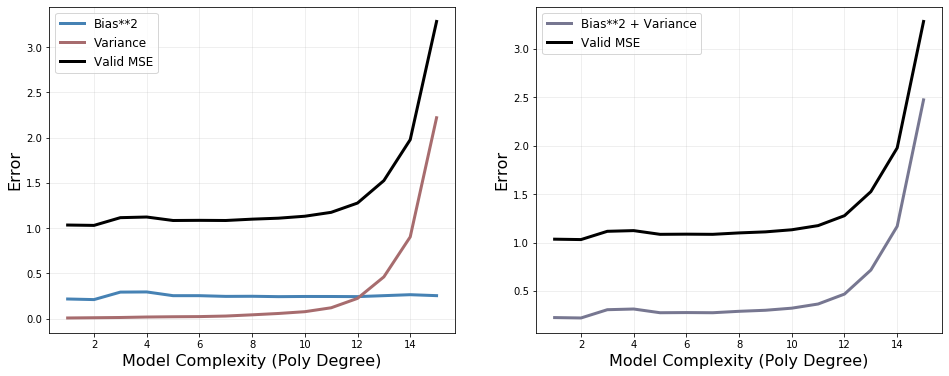

In [41]:
bias_squared, variance, mse_valid = bias_variance_study(30, 500, train_frac=0.80,
                                                        sigma=0.9, max_deg=15,
                                                        random_state=1241)

### [5 points] Problem 4: Syllabus quiz
***

Please read the [syllabus](https://github.com/BoulderDS/CSCI-4622-Machine-
Learning-fa20/blob/master/info/syllabus.md) carefullly and finish the [Syllabus
quiz](https://docs.google.com/forms/d/e/1FAIpQLSc02WXElDIhHrp2GY1Pf1D5qI2LVUr12a0HgVuP3unenLT1MQ/viewform?usp=pp_url).
You do not need to answer anything here. The Markdown cell is only for grading
convenience.

YOUR ANSWER HERE

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is
a simple anonymous feedback
[survey](https://docs.google.com/forms/d/e/1FAIpQLScy3B9xtnkqziMjoo995YUR0pNcVw04IHgRixxaWfHUdZ1xiw/viewform?usp=pp_url)
to solicit your feedback for how to improve the course.